# Model Selection

In this notebook I will train several models and evaluate how effectively they predict instances of fraud using data based on [this dataset from Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud).
 
Each row in `fraud_data.csv` corresponds to a credit card transaction. Features include confidential variables `V1` through `V28` as well as `Amount` which is the amount of the transaction. 
 
The target is stored in the `class` column, where a value of 1 corresponds to an instance of fraud and 0 corresponds to an instance of not fraud.

In [33]:
import numpy as np
import pandas as pd
import os

### Fraud rate

In [34]:
fraud_file = os.path.join("Resources", "fraud_data.csv")
fraud_df = pd.read_csv(fraud_file)

def fraud_rate():
    fraudrate = len(fraud_df[fraud_df['Class']==1])/len(fraud_df)
    return fraudrate

fraud_rate()

0.016410823768035772

In [35]:
# splitting to get X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X = fraud_df.iloc[:,:-1]
y = fraud_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Dummy classifier evaluation

Using `X_train`, `X_test`, `y_train`, and `y_test`, I will train a dummy classifier that classifies everything as the majority class of the training data. Then compute the accuracy and recall

*The below function will return a tuple with two floats, i.e. `(accuracy score, recall score)`.*

In [36]:
def dummy_score():
    from sklearn.dummy import DummyClassifier
    from sklearn.metrics import recall_score, accuracy_score
    
    dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
    y_predictions = dummy_majority.predict(X_test)
    accuracy = accuracy_score(y_test, y_predictions)
    recall = recall_score(y_test, y_predictions)
    
    return (accuracy, recall)

print(f"Dummy Classifier Accuracy: {dummy_score()[0]}\nDummy Classifier Recall: {dummy_score()[1]}")

Dummy Classifier Accuracy: 0.9852507374631269
Dummy Classifier Recall: 0.0


### Support Vector Classification evaluation

Now I train a SVC classifer using the default parameters. Then compute the accuracy, recall, and precision of this classifier.

*The below function will return a tuple with three floats, i.e. `(accuracy score, recall score, precision score)`.*

In [37]:
def svc_class_scores():
    from sklearn.metrics import recall_score, precision_score, accuracy_score
    from sklearn.svm import SVC
    
    svm = SVC().fit(X_train, y_train)
    y_predictions = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_predictions)
    recall = recall_score(y_test, y_predictions)
    precision = precision_score(y_test, y_predictions)
    return (accuracy, recall, precision)

print(f"SVC Accuracy: {svc_class_scores()[0]}\nSVC Recall: {svc_class_scores()[1]}\nSVC Precision: {svc_class_scores()[2]}")

SVC Accuracy: 0.9907817109144543
SVC Recall: 0.375
SVC Precision: 1.0


### Tunning the SVC parameters

Using the SVC classifier with parameters `{'C': 1e9, 'gamma': 1e-07}`, I compute the confusion matrix using a threshold of -220 on the decision function.

*Below function returns a confusion matrix, a 2x2 numpy array with 4 integers.*

In [38]:
def svc_confuse():
    from sklearn.metrics import confusion_matrix
    from sklearn.svm import SVC

    y_scores = SVC(C=1e9, gamma = 1e-07).fit(X_train, y_train).decision_function(X_test)
    y_scores[y_scores>-220] = 1
    y_scores[y_scores<=-220] = 0
    confusion = confusion_matrix(y_test, y_scores)
    return confusion

svc_confuse()

array([[5320,   24],
       [  14,   66]], dtype=int64)

### Logistic regression evaluation

Now I train a logisitic regression classifier with default parameters using X_train and y_train.

For the logisitic regression classifier, I will create a precision recall curve and a roc curve using y_test and the probability estimates for X_test (probability it is fraud).


<IPython.core.display.Javascript object>


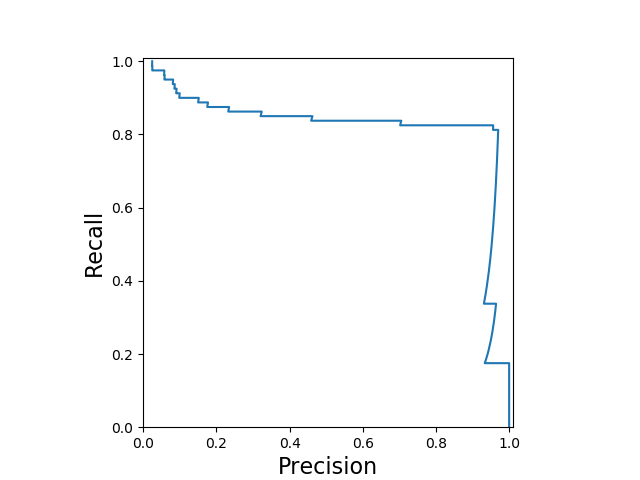

C:\Users\Landrover\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


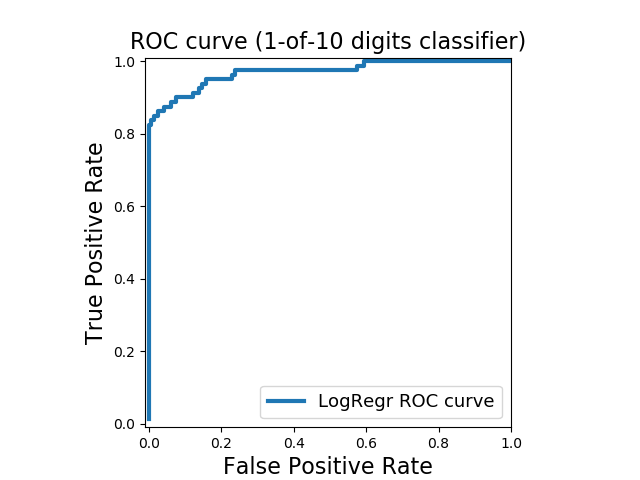

C:\Users\Landrover\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [39]:
def logistic_curves():
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_recall_curve, roc_curve, auc 
    %matplotlib notebook
    import matplotlib.pyplot as plt
  
    clf = LogisticRegression().fit(X_train, y_train)
    y_scores = clf.predict_proba(X_test)[:,1]
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

    plt.figure()
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.plot(precision, recall, label='Precision-Recall Curve')
    plt.xlabel('Precision', fontsize=16)
    plt.ylabel('Recall', fontsize=16)
    plt.axes().set_aspect('equal')
    plt.show()
    
    
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores)
    roc_auc_lr = auc(fpr_lr, tpr_lr)

    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.axes().set_aspect('equal')
    plt.show()

logistic_curves()

### Logistic parameter tuning

I will now pPerform a grid search over the below parameters for a Logisitic Regression classifier, using recall for scoring and the default 3-fold cross validation.

`'penalty': ['l1', 'l2']`

`'C':[0.01, 0.1, 1, 10, 100]`

From `.cv_results_`, I will create an array of the mean test scores of each parameter combination.

*The below function will return a 5 by 2 numpy array with 10 floats.* 


In [40]:
def logistic_grids():    
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import LogisticRegression

    clf = LogisticRegression()
    grid_values = {'penalty': ['l1', 'l2'], 'C':[0.01, 0.1, 1, 10, 100]}

    # default metric to optimize over grid parameters: accuracy
    grid_clf_acc = GridSearchCV(clf, param_grid = grid_values, scoring='recall')
    grid_clf_acc.fit(X_train, y_train)
    y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 
    test_scores = grid_clf_acc.cv_results_['mean_test_score'].reshape(5,2)
    
    return test_scores

scores = logistic_grids()
scores

array([[0.66666667, 0.76086957],
       [0.80072464, 0.80434783],
       [0.8115942 , 0.8115942 ],
       [0.80797101, 0.8115942 ],
       [0.80797101, 0.8115942 ]])

<IPython.core.display.Javascript object>


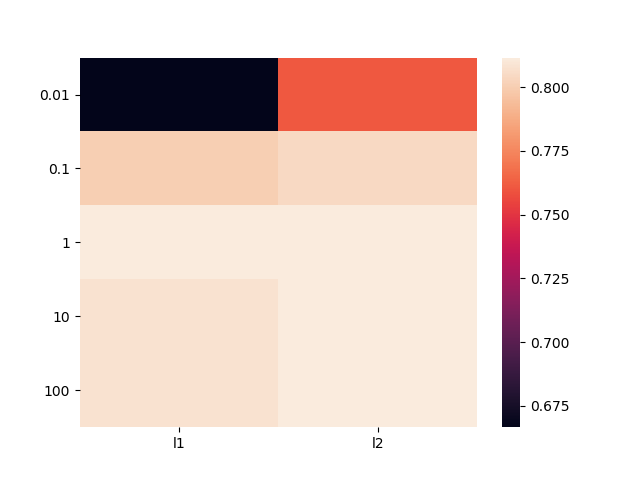

In [41]:
# Using the following function to help visualize results from the grid search
def GridSearch_Heatmap(scores):
    %matplotlib notebook
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure()
    sns.heatmap(scores.reshape(5,2), xticklabels=['l1','l2'], yticklabels=[0.01, 0.1, 1, 10, 100])
    plt.yticks(rotation=0);

GridSearch_Heatmap(scores)